In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain3 import Gain3
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker2 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [3]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0, 1]
gSlope_bound = [0,0.01]


# Generate a batch of trials with linear gain

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound)

In [5]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 4,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [-0.9, 0.9],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g0_bound': [0, 1],
 'gSlope_bound': [0, 0.01]}

In [5]:
[x, y, mask, allParams, g, gainParams] = task.get_trial_batch()

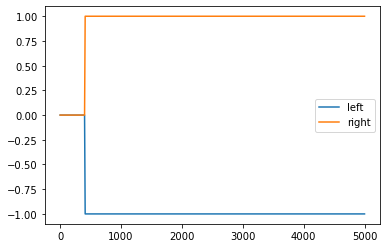

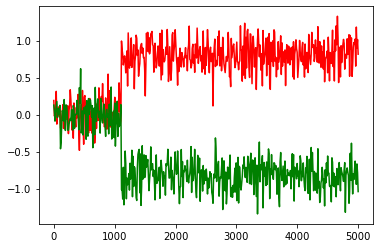

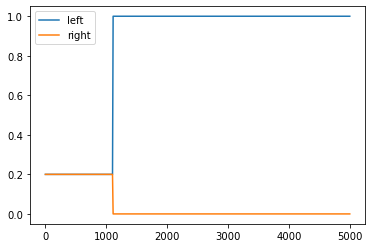

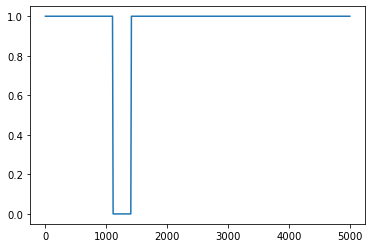

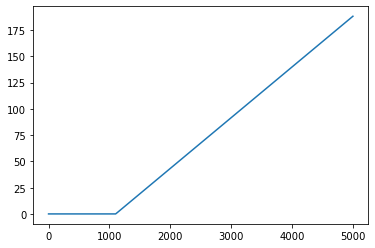

[0.1849521  0.04827963]


In [6]:
# 1a: left tartet red (-1) or green (+1)
# 1b: right target red (-1) or green (+1)
# 2a: red coherence (-1 to 1) ()
# 2b: green coherence (-1 to 1) (G-R) / (R+G)
trialIn = x[1,:,:]
trialOut = y[1,:,:]
trialMask = mask[1,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

plt.figure()
plt.plot(time, trialIn[:,2], color = 'red')
plt.plot(time, trialIn[:,3], color = 'green')
# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])
# plot gain
plt.figure()
plt.plot(time, g[1,:,:])
plt.show()
print(gainParams[1,:])

# Set Network params

In [6]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [7]:
try:
    model.destruct()
except:
    pass

model = Gain3(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [7]:
# check model
# vars(model)

# Set Training params & Train

In [8]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  "./weights/Gain31stTryRecNoise0.1"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [9]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./losses/Gain31stTryRecNoise0.1.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.367695
Iter 1000, Minibatch Loss= 0.369727
Iter 1500, Minibatch Loss= 0.364602
Iter 2000, Minibatch Loss= 0.365489
Iter 2500, Minibatch Loss= 0.363869
Iter 3000, Minibatch Loss= 0.362061
Iter 3500, Minibatch Loss= 0.366819
Iter 4000, Minibatch Loss= 0.371172
Iter 4500, Minibatch Loss= 0.364956
Iter 5000, Minibatch Loss= 0.363240
Iter 5500, Minibatch Loss= 0.071914
Iter 6000, Minibatch Loss= 0.363091
Iter 6500, Minibatch Loss= 0.359636
Iter 7000, Minibatch Loss= 0.361547
Iter 7500, Minibatch Loss= 0.362604
Iter 8000, Minibatch Loss= 0.364233
Iter 8500, Minibatch Loss= 0.358981
Iter 9000, Minibatch Loss= 0.223374
Iter 9500, Minibatch Loss= 0.115250
Iter 10000, Minibatch Loss= 0.146729
Iter 10500, Minibatch Loss= 0.130953
Iter 11000, Minibatch Loss= 0.145610
Iter 11500, Minibatch Loss= 0.143361
Iter 12000, Minibatch Loss= 0.066417
Iter 12500, Minibatch Loss= 0.060912
I

Text(0.5, 1.0, 'Loss During Training')

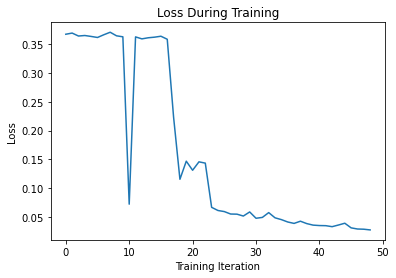

In [10]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

# Test 5000 trials

In [11]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [12]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, gainParams] = task.get_trial_batch()
    outputs, states, inputs = model.test(x,g)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


/home/tianwang/anaconda3/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


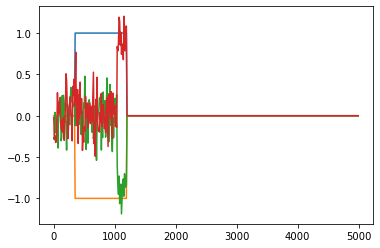

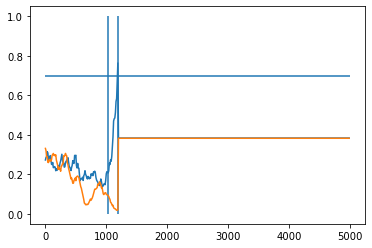

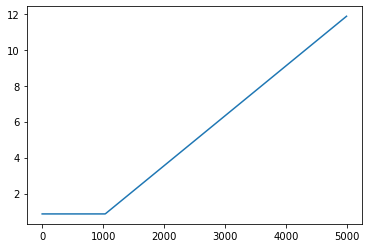

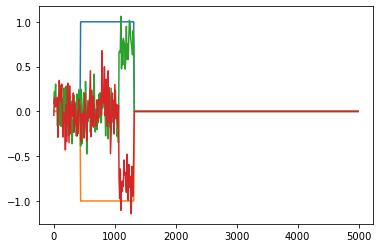

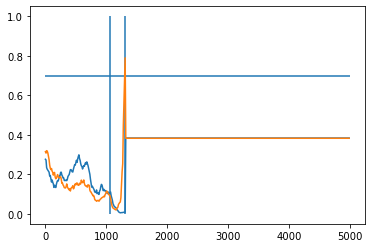

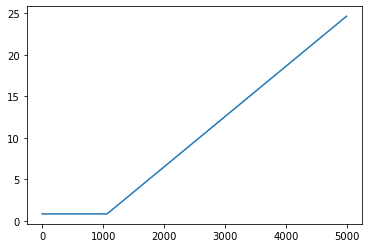

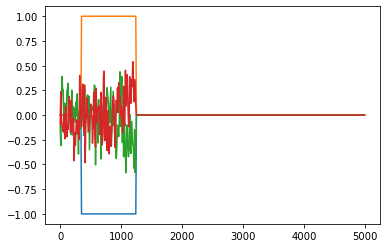

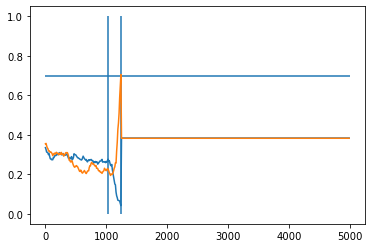

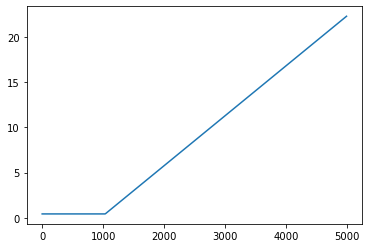

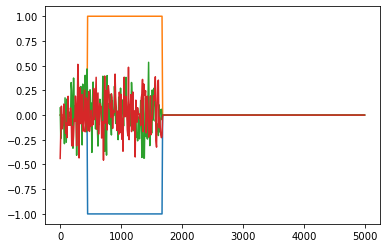

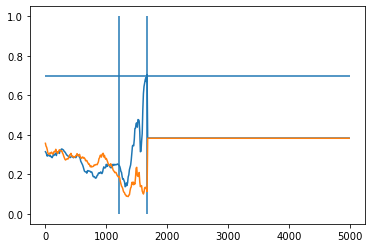

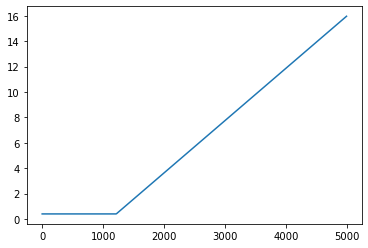

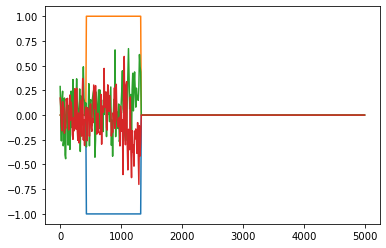

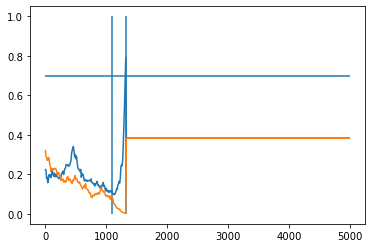

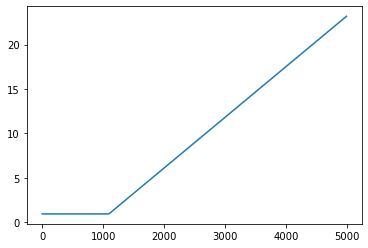

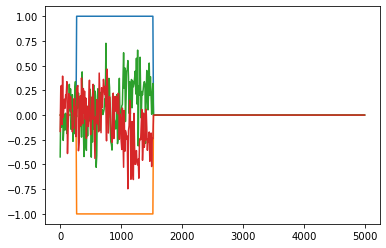

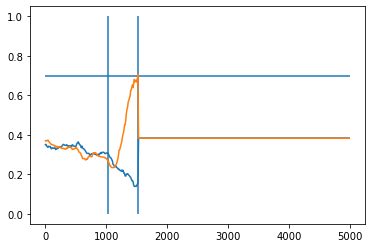

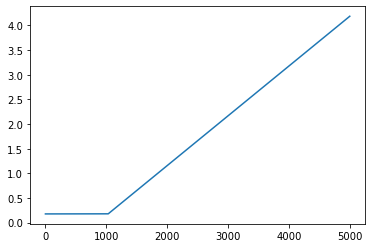

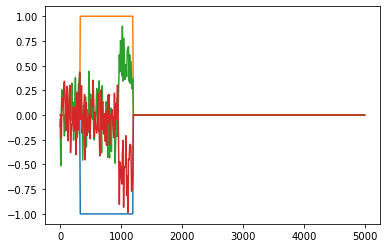

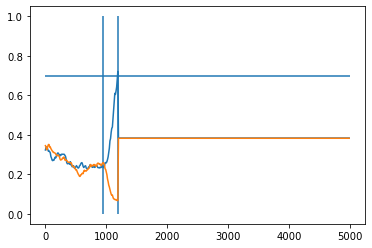

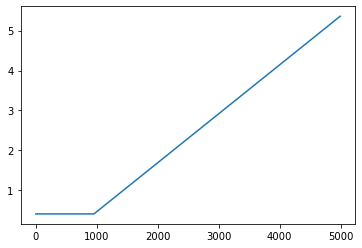

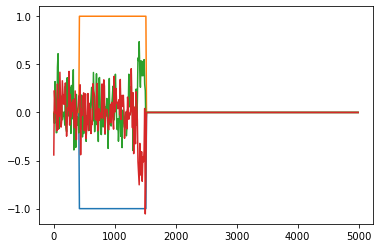

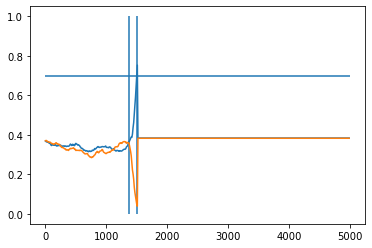

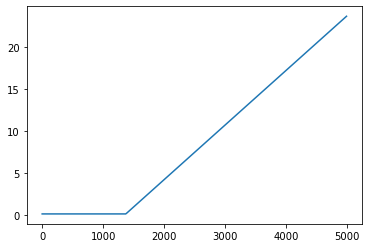

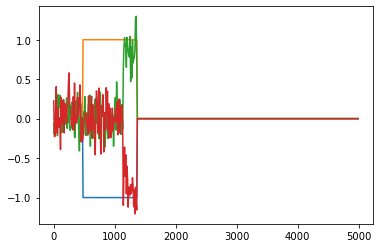

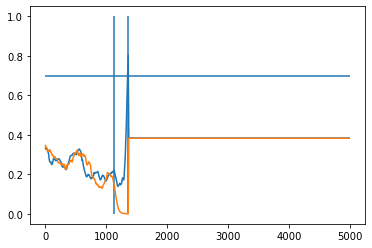

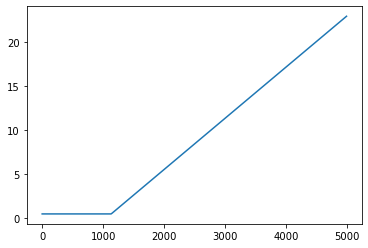

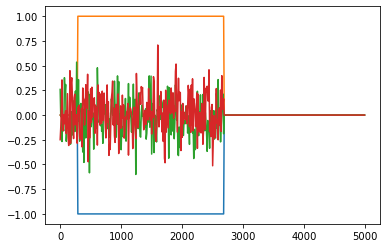

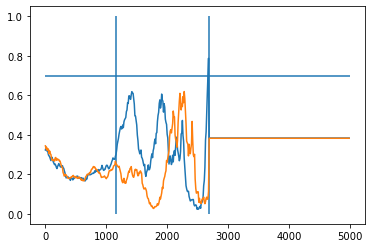

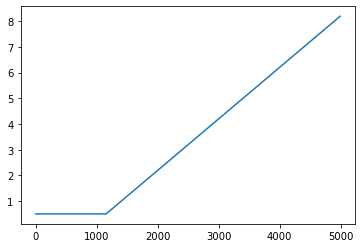

In [13]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10,20):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 3])
    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
    plt.figure()
    plt.plot(np.arange(0, T, 10), g[i, :, :])

In [14]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))


Overall Accuracy: 0.9664
Negative RT trials ratio: 0.0


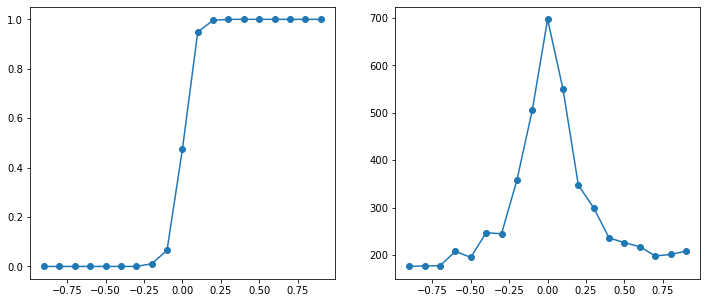

In [15]:
# psychrometric curve 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])


# RT within same coherence

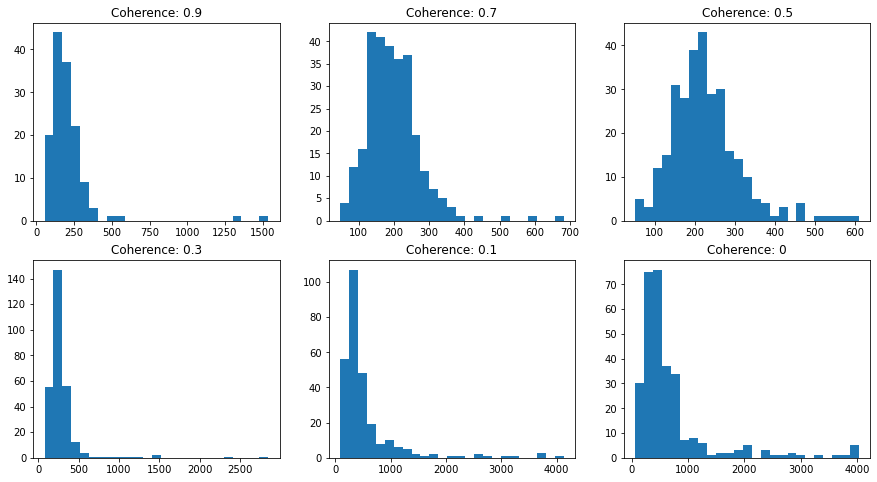

In [16]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# Check the activity of each recurrent unit

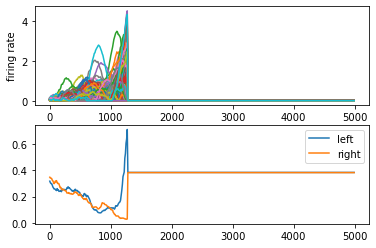

In [18]:
trial_num = 20
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

In [19]:
model.destruct()

# 2. Load the model trained before

In [31]:
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100
experiment = 'interactive'
name = 'basic'

rec_noise = 0.5
thres = 0.7

g0_bound = [0, 1]
gSlope_bound = [0,0.05]

########################################
#### set weight path
########################################
weightsPath = "./weights/Gain31stTryRecNoise0.1.npz"

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound)

network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = rec_noise

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["loss_function"] = "rt_mask_mse"
if thres == 0.6:
    network_params["rt_mask_mse"] = rt_mask_mse_06
elif thres == 0.7:
    network_params["rt_mask_mse"] = rt_mask_mse_07
elif thres == 0.8:
    network_params["rt_mask_mse"] = rt_mask_mse_08
        
network_params['load_weights_path'] =  weightsPath

try:
    model2.destruct()
except:
    pass

model2 = Gain3(network_params)
model2.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model2.decision_threshold = network_params.get("decision_threshold", np.inf)

# Test 5000 trials to examine performance

In [32]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model2.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model2.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [33]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, gainParams] = task.get_trial_batch()
    outputs, states, inputs = model2.test(x,g)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


/home/tianwang/anaconda3/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


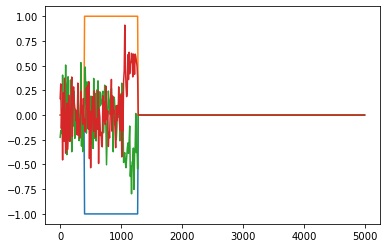

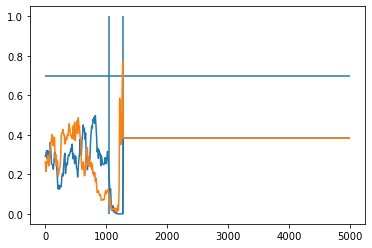

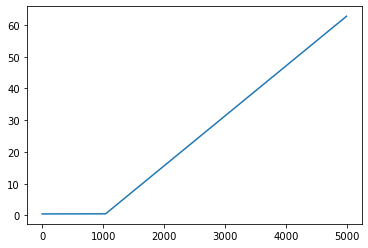

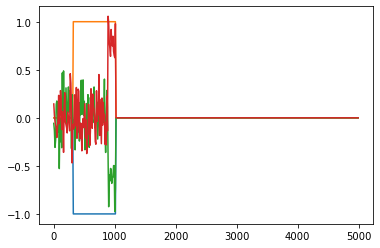

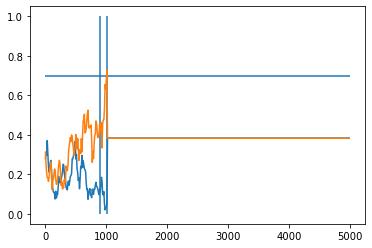

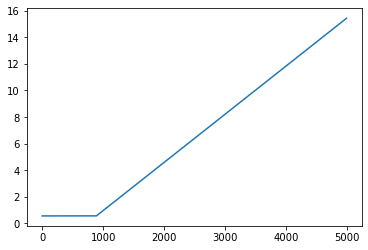

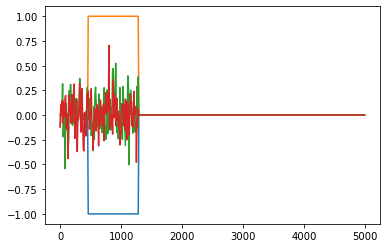

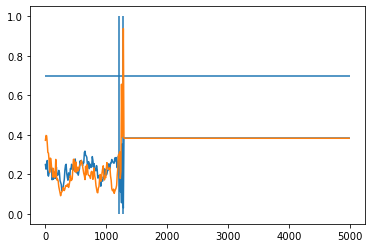

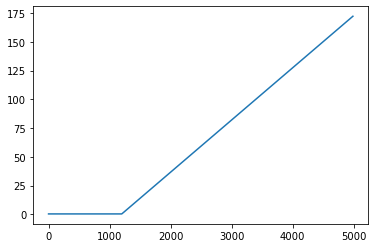

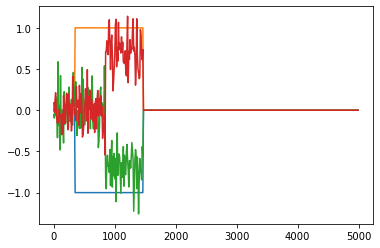

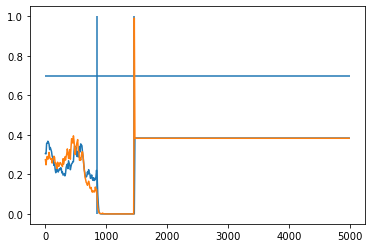

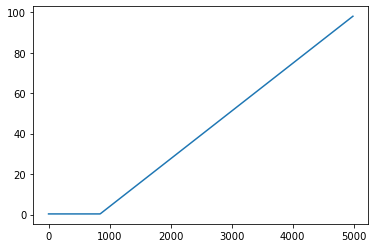

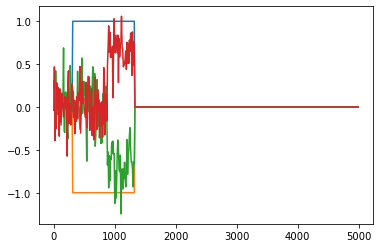

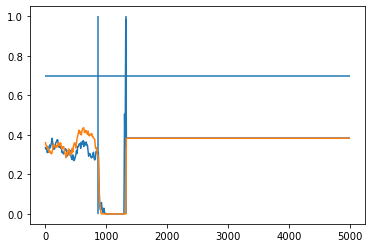

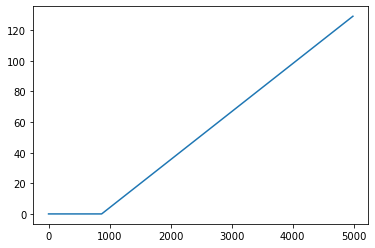

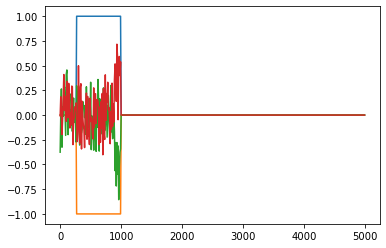

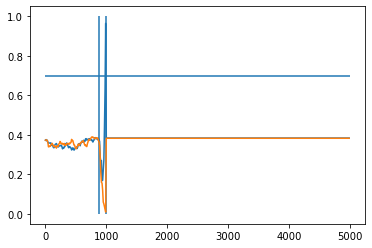

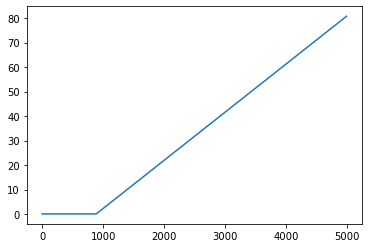

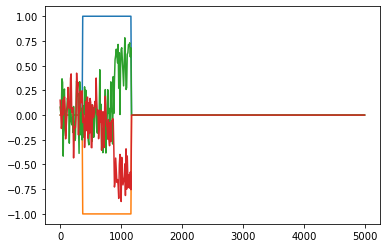

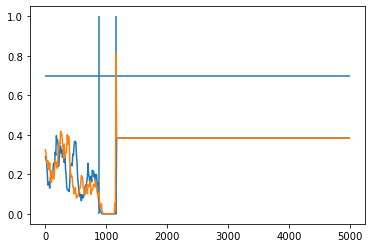

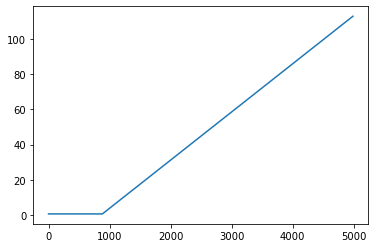

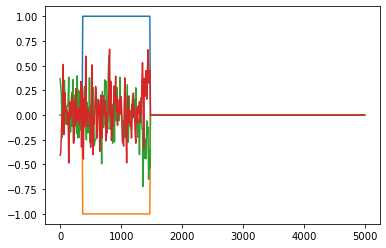

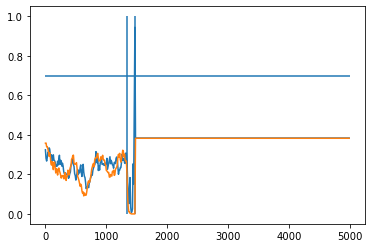

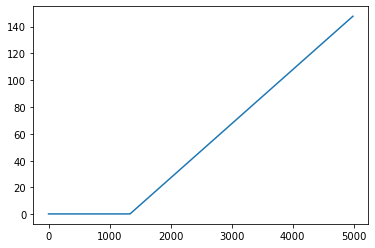

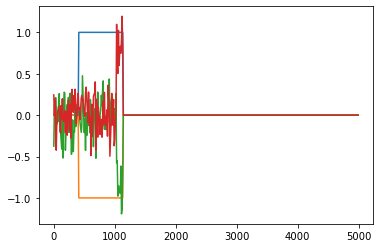

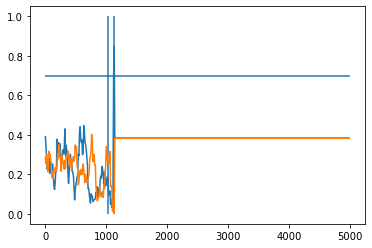

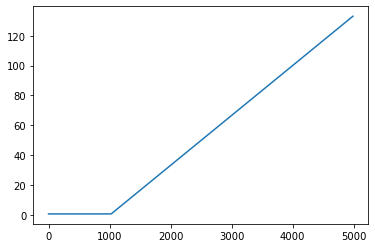

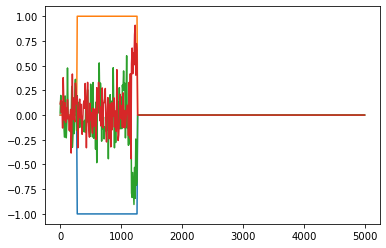

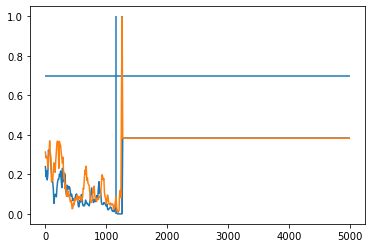

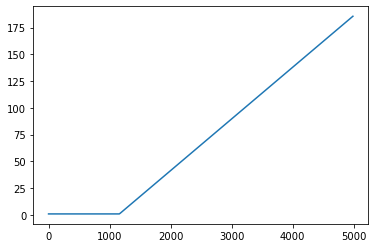

In [34]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10,20):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 3])
    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
    plt.figure()
    plt.plot(np.arange(0, T, 10), g[i, :, :])

# Generate a dataframe

In [38]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

resultPath = "./resultData/Gain31stTryRecNoise0.1.csv"
checker_df.to_csv(resultPath)

print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))

Overall Accuracy: 0.912
Negative RT trials ratio: 0.0164


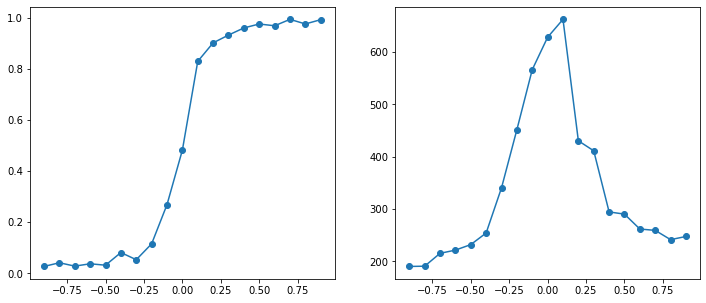

In [36]:
# psychrometric curve 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

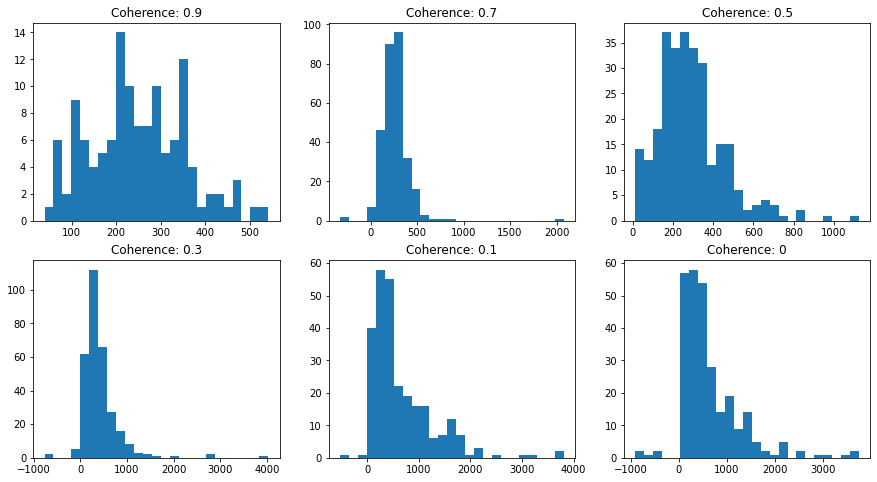

In [37]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# Check the activity of each recurrent unit

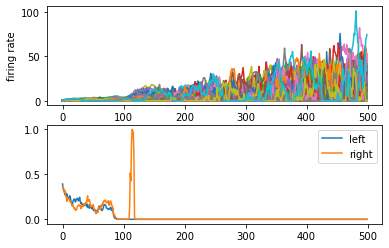

In [16]:
plt.figure()
plt.subplot(211)
_ = plt.plot(rnn_state[1,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(rnn_out[0,:,0], label = "left")
_ = plt.plot(rnn_out[0,:,1], label = "right")
plt.legend()

In [28]:
model2.destruct()